In [54]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

In [55]:
# Root directory of your dataset
base_dir = './'  # Adjust if needed
output_dir = 'combined_signals'  # Save mixed signals here

os.makedirs(output_dir, exist_ok=True)

In [56]:
# Subjects and levels
subjects = [f"sub{str(i).zfill(2)}" for i in range(1, 11)]
levels = [f"l{i}" for i in range(1, 6)]

print (subjects)
print (levels)

['sub01', 'sub02', 'sub03', 'sub04', 'sub05', 'sub06', 'sub07', 'sub08', 'sub09', 'sub10']
['l1', 'l2', 'l3', 'l4', 'l5']


In [57]:
for sub in subjects:
    for level in levels:
        prefix = f"{sub}_snr00dB_{level}_c0"
        print(f"Processing: {prefix}")

        sub_folder = os.path.join(base_dir, sub, level)

        try:
            fecg = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_fecg1"))
            mecg = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_mecg"))
            noise1 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise1"))
            noise2 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise2"))

            f_ecg = fecg.p_signal[:, 0]
            m_ecg = mecg.p_signal[:, 0]
            n1 = noise1.p_signal[:, 0]
            n2 = noise2.p_signal[:, 0]

            min_len = min(len(f_ecg), len(m_ecg), len(n1), len(n2))
            f_ecg = f_ecg[:min_len]
            m_ecg = m_ecg[:min_len]
            n1 = n1[:min_len]
            n2 = n2[:min_len]

            mixed_signal = f_ecg + m_ecg + n1 + n2
            mixed_signal = mixed_signal.reshape(-1, 1)

            # Combine output name safely (no '.'!)
            record_name = f"{sub}_{level}_c0_combined"
            
            record_path = os.path.join(output_dir, record_name)


            wfdb.wrsamp(
                record_name=record_name,
                fs=fecg.fs,
                units=['mV'],
                sig_name=['combined_ecg'],
                p_signal=mixed_signal
            )

            #print(f"Saved to {record_path}.hea / .dat")
            # Move the generated .hea and .dat to the combined_signals directory
            os.makedirs(output_dir, exist_ok=True)
            for ext in ['hea', 'dat']:
                os.replace(
                    f"{record_name}.{ext}",
                    os.path.join(output_dir, f"{record_name}.{ext}")
                )

        except Exception as e:
            print(f"Error processing {prefix}: {e}")



Processing: sub01_snr00dB_l1_c0
Processing: sub01_snr00dB_l2_c0
Processing: sub01_snr00dB_l3_c0
Processing: sub01_snr00dB_l4_c0
Processing: sub01_snr00dB_l5_c0
Processing: sub02_snr00dB_l1_c0
Processing: sub02_snr00dB_l2_c0
Processing: sub02_snr00dB_l3_c0
Processing: sub02_snr00dB_l4_c0
Processing: sub02_snr00dB_l5_c0
Processing: sub03_snr00dB_l1_c0
Processing: sub03_snr00dB_l2_c0
Processing: sub03_snr00dB_l3_c0
Processing: sub03_snr00dB_l4_c0
Processing: sub03_snr00dB_l5_c0
Processing: sub04_snr00dB_l1_c0
Processing: sub04_snr00dB_l2_c0
Processing: sub04_snr00dB_l3_c0
Processing: sub04_snr00dB_l4_c0
Processing: sub04_snr00dB_l5_c0
Processing: sub05_snr00dB_l1_c0
Processing: sub05_snr00dB_l2_c0
Processing: sub05_snr00dB_l3_c0
Processing: sub05_snr00dB_l4_c0
Processing: sub05_snr00dB_l5_c0
Processing: sub06_snr00dB_l1_c0
Processing: sub06_snr00dB_l2_c0
Processing: sub06_snr00dB_l3_c0
Processing: sub06_snr00dB_l4_c0
Processing: sub06_snr00dB_l5_c0
Processing: sub07_snr00dB_l1_c0
Processi

Plot combined signal and separated signals 

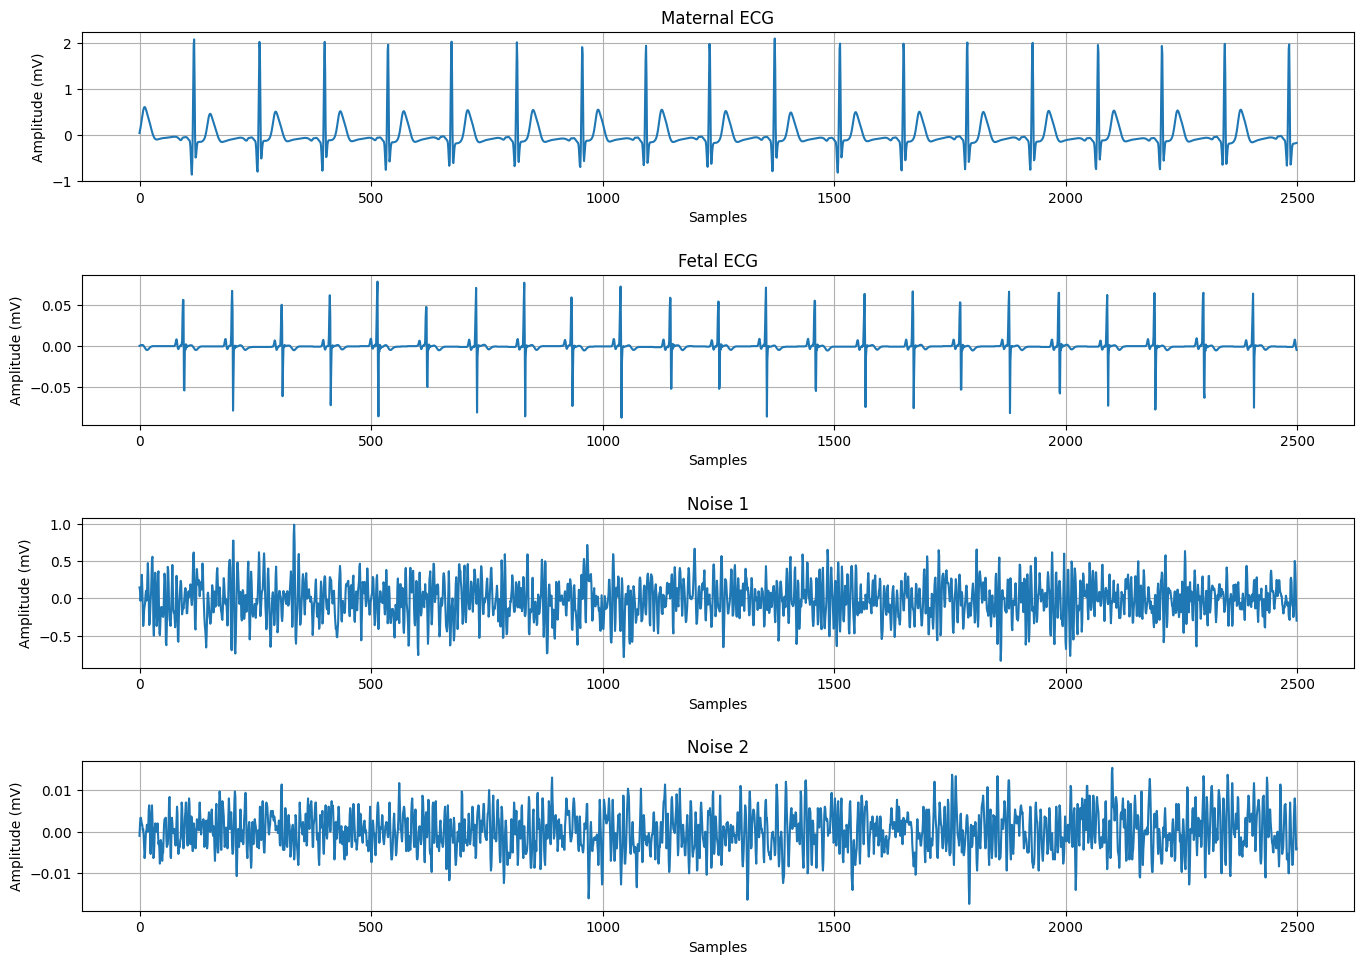

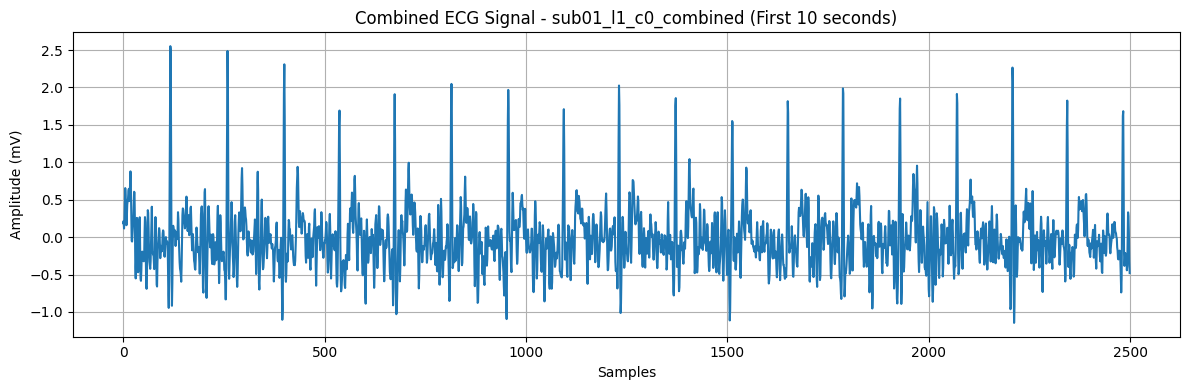

In [60]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Setup
record_name = 'sub01_l1_c0_combined'  # Change as needed
record_path = os.path.join('combined_signals', record_name)

# Load combined signal
record = wfdb.rdrecord(record_path)
combined_signal = record.p_signal[:, 0]
fs = record.fs
seconds = 10
samples_to_plot = int(seconds * fs)

# Load original individual signals (same base name, but from original folders)
subject = "sub01"
level = "l1"
base_dir = "./"
prefix = f"{subject}_snr00dB_{level}_c0"
sub_folder = os.path.join(base_dir, subject, level)

# Read components
fetal = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_fecg1"))
maternal = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_mecg"))
noise1 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise1"))
noise2 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise2"))

# Extract and trim
f_ecg = fetal.p_signal[:, 0][:samples_to_plot]
m_ecg = maternal.p_signal[:, 0][:samples_to_plot]
n1 = noise1.p_signal[:, 0][:samples_to_plot]
n2 = noise2.p_signal[:, 0][:samples_to_plot]
combined_signal = combined_signal[:samples_to_plot]

# Plot components + combined
labels = ['Maternal ECG', 'Fetal ECG', 'Noise 1', 'Noise 2']
signals = [m_ecg, f_ecg, n1, n2]

plt.figure(figsize=(14, 12))
for i, sig in enumerate(signals):
    plt.subplot(5, 1, i+1)
    plt.plot(sig)
    plt.title(labels[i])
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV)")
    plt.grid()


plt.tight_layout(pad=2)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(combined_signal[:int(fs*seconds)])
plt.title(f"Combined ECG Signal - {record_name} (First {seconds} seconds)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.grid()
plt.tight_layout()
plt.show()
